In [1]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import integrate, signal, fftpack
from functools import reduce
import mplcursors

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp, retEEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import find_nearest_ind, get_stim_events, get_evoked_traces
from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [5]:
%matplotlib notebook

## Functions

In [6]:
### FUNCTION to get bad trials ###
def get_good_trials(exp_inst, known_bad_chs=[]):
    print(known_bad_chs)
    TRIAL_RMS_THRESH = 200.0
    SHORT_WINDOW = [0.001, 0.003] # looking in window from 1 to 3 ms for high voltage difference (response-baseline)
    DIFF_THRESH = 200.0 # uV
    CH_FRACTION_THRESH = 0.34
    V_MAX = 3000.0 # uV

    if exp_inst.experiment_type == 'spontaneous':
        print('This experiment has no stimuli.')
        return
    
    ## Load eeg data and stim log ##
    expstimlog = pd.read_csv(exp_inst.stimulus_log_file)
    expstimlog['good'] = np.zeros(expstimlog.shape[0], dtype='bool')
    eegsr = 2500
    eegdata, eegts = exp_inst.load_eegdata(frequency=eegsr)
    ## Cycle through all stim in all sweeps to get traces ##
    for st_type in np.sort(expstimlog.stim_type.unique()):
        for parami in np.sort(expstimlog.loc[expstimlog.stim_type == st_type, 'parameter'].unique()):
            param_mask = (expstimlog.stim_type == st_type) & (expstimlog.parameter == parami)
            for sweepi in np.sort(expstimlog.loc[param_mask, 'sweep'].unique()):
                ## Get event times and traces ##
                events = get_stim_events(expstimlog, st_type, parami, sweepi, remove_bad_epochs=False)
                event_traces, event_ts = get_evoked_traces(
                        eegdata,
                        eegts,
                        events,
                        1.0,
                        1.0,
                        exp_inst.ephys_params['EEG']['sample_rate']
                    )
                ## Remove known bad chs that will skew the results ##
                GOOD_CHS = np.array([x for x in range(eegdata.shape[1]) if x not in known_bad_chs])
                event_traces = event_traces[:, GOOD_CHS, :]
                ## RMS of baseline signal ##
                full_baseline_inds = event_ts < -0.002 # 2 ms before stim delivery
                baseline_rms = np.power(np.mean(np.power(
                    event_traces[full_baseline_inds, :, :].astype('float32'), 2), 0), 0.5)

                ## Response - baseline voltage diff ##
                short_baseline_inds = np.nonzero((event_ts > -SHORT_WINDOW[1]) & (event_ts < -SHORT_WINDOW[0]))[0]
                short_response_inds = np.nonzero((event_ts > SHORT_WINDOW[0]) & (event_ts < SHORT_WINDOW[1]))[0]
                voltage_diff = np.abs(
                    np.mean(event_traces[short_response_inds,:,:], axis=0) - 
                    np.mean(event_traces[short_baseline_inds,:,:], axis=0)
                )
                
                ## Max voltage threshold ##
                longinds = np.nonzero((event_ts < -0.05) | (event_ts > 0.05))[0]
                abs_voltage_max = np.max(np.abs(event_traces[longinds, :]), axis=0)
                
                ## Find good trials ##
                GOOD_TRIALS = reduce(
                    np.intersect1d,
                    (
                        np.nonzero(np.median(baseline_rms, axis=0) < TRIAL_RMS_THRESH)[0],
                        np.nonzero(np.mean(voltage_diff > DIFF_THRESH, axis=0) <= CH_FRACTION_THRESH)[0],
                        np.nonzero(np.max(abs_voltage_max, axis=0) < V_MAX)[0]
                    )
                )
                
                TRIAL_MASK = (
                    (expstimlog.stim_type == st_type) &
                    (expstimlog.parameter == parami) &
                    (expstimlog.sweep == sweepi)
                )
                expstimlog.loc[TRIAL_MASK, 'good'] = np.isin(np.arange(events.shape[0]), GOOD_TRIALS)
    
    del eegdata
    del eegts
    return expstimlog

#### Plot electrodes

## Load experiment instance

In [10]:
dfolder = r'B:\mouse657905\estim_2023-01-31_10-56-45\experiment1\recording1'
exp = EEGexp(dfolder, preprocess=True, make_stim_csv=False)

This data does not contain an EEG recording.
Experiment type: electrical stimulation
Aligning timestamps for all datasets...
probeB AP and LFP
Using previous timestamp alignment. Delete file at B:\mouse657905\estim_2023-01-31_10-56-45\experiment1\probeB_sorted\continuous\Neuropix-PXI-100.0\timestamps_master_clock.npy to realign timestamps.
Creating B:\mouse657905\estim_2023-01-31_10-56-45\experiment1\probeB_sorted\continuous\Neuropix-PXI-100.0\spike_times_master_clock.npy
probeE AP and LFP
Using previous timestamp alignment. Delete file at B:\mouse657905\estim_2023-01-31_10-56-45\experiment1\probeE_sorted\continuous\Neuropix-PXI-100.0\timestamps_master_clock.npy to realign timestamps.
Creating B:\mouse657905\estim_2023-01-31_10-56-45\experiment1\probeE_sorted\continuous\Neuropix-PXI-100.0\spike_times_master_clock.npy


### Load EEG data, stim log with good trials column, and good_chs list

In [8]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])
print(exp.ephys_params['EEG']['sample_rate'])

2500


In [9]:
bad_chs = [29]
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [10]:
stim_log = get_good_trials(exp, known_bad_chs=bad_chs)

[29]


In [11]:
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good
0,biphasic,40,431.64557,431.64597,0.0004,0,False
1,biphasic,40,438.25267,438.25307,0.0004,0,True
2,biphasic,40,445.71502,445.71542,0.0004,0,True
3,biphasic,40,452.22010,452.22050,0.0004,0,True
4,biphasic,40,459.49547,459.49587,0.0004,0,True


In [12]:
plot_before = 1.0 # s, look at 100 ms pre-stim
plot_after = 1.0 # s, look at 500 ms post-stim

all_traces = {}
for st_type in stim_log.stim_type.unique():
    all_traces[st_type] = {}
    
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
        all_traces[st_type][parami] = {}
        param_mask = (stim_log.stim_type == st_type) & (stim_log.parameter == parami)
        for sweepi in np.sort(stim_log.loc[param_mask, 'sweep'].unique()):
            print('{} - {}, sweep {:d}'.format(st_type, str(parami), sweepi))
            
            ## Get event times ##
            events = get_stim_events(stim_log, st_type, parami, sweepi, remove_bad_epochs=True)
            if len(events) == 0:
                print('no good trials found')
                continue
                
            ## Get event traces ##
            event_traces, event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                events,
                plot_before,
                plot_after,
                exp.ephys_params['EEG']['sample_rate']
            )
            print('  {} trials'.format(len(events)))
            
            ## Store traces ##
            all_traces[st_type][parami][sweepi] = [event_ts, event_traces]

biphasic - 40, sweep 0
  104 trials
biphasic - 40, sweep 1
  85 trials
biphasic - 40, sweep 2
  106 trials
circle - white, sweep 0
  117 trials


### Look at spectrum of chs

In [13]:
frex, Pxx = signal.welch(
    eeg_data[:(120 * exp.ephys_params['EEG']['sample_rate'])+1, :],
    exp.ephys_params['EEG']['sample_rate'],
    nperseg=2 * exp.ephys_params['EEG']['sample_rate'],
    axis=0
)

<IPython.core.display.Javascript object>


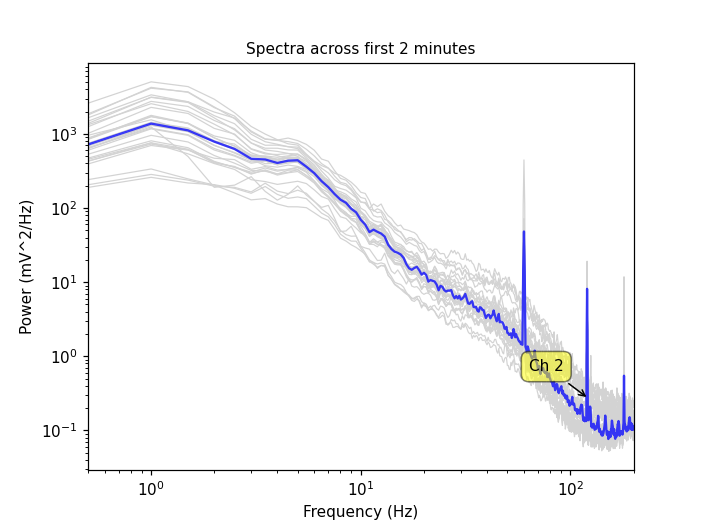

Text(0.5, 1.0, 'Spectra across first 2 minutes')

In [14]:
frinds = frex < 200

fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds,:], color='lightgray', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(ind))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(frex[frinds], np.median(Pxx, axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim([0.5, 200])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes')
# ax.legend()

In [15]:
bad_chs = [29]
print(bad_chs)
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
BAD_CHS = np.array(bad_chs)

[29]


<IPython.core.display.Javascript object>


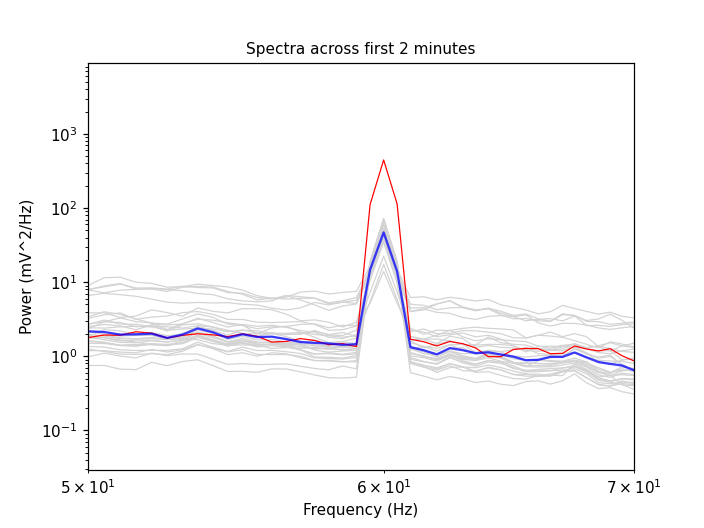

Text(0.5, 1.0, 'Spectra across first 2 minutes')

In [16]:
fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds,:][:,GOOD_CHS], color='lightgray', linewidth=0.8)
if BAD_CHS.size > 0:
    ax.loglog(frex[frinds], Pxx[frinds,:][:,BAD_CHS], color='r', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(GOOD_CHS[ind]))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(frex[frinds], np.median(Pxx[:,GOOD_CHS], axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim([50, 70])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes')
# ax.legend()

In [17]:
# bad_chs = [6,9,13,14]
print(bad_chs)
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
BAD_CHS = np.array(bad_chs)

[29]


### Look at evoked responses

<IPython.core.display.Javascript object>


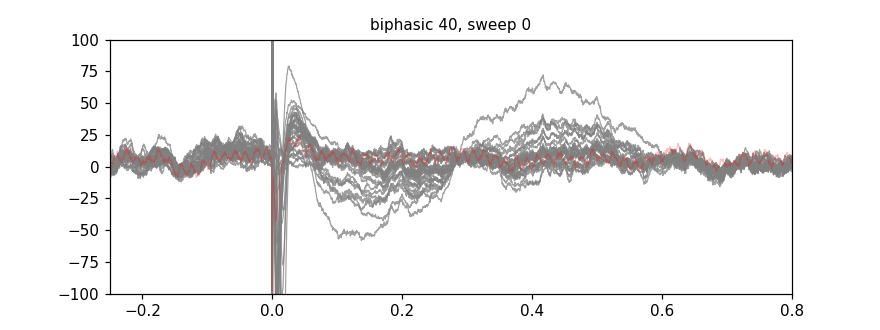

<IPython.core.display.Javascript object>


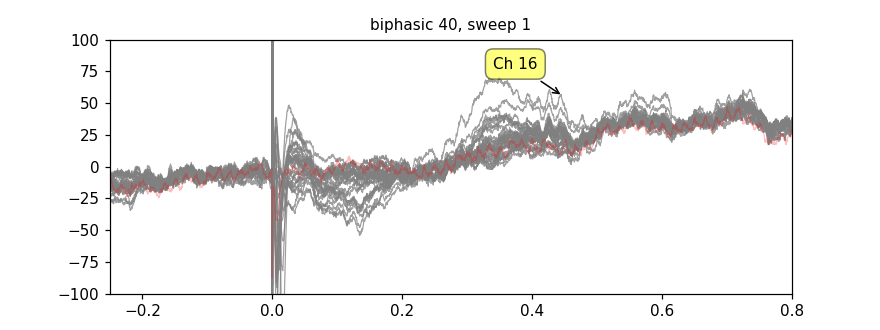

<IPython.core.display.Javascript object>


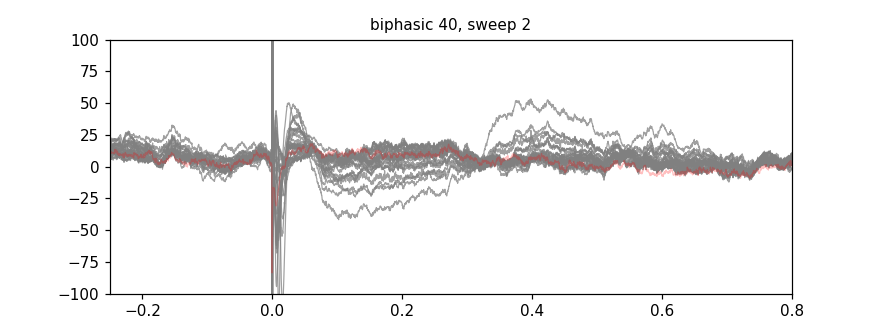

<IPython.core.display.Javascript object>


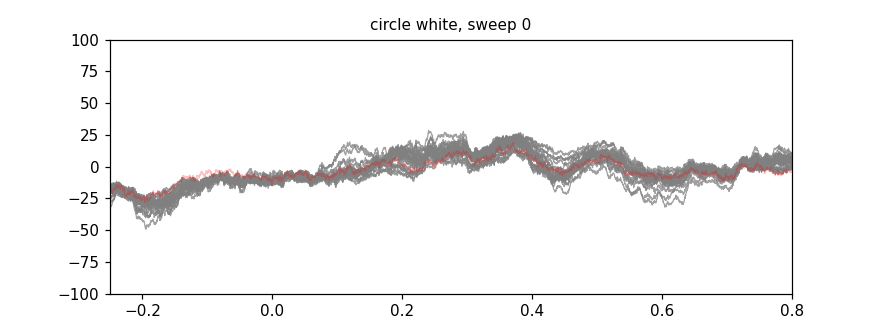

In [18]:
for stimi, paramdict in all_traces.items():
    for parami, sweepdict in paramdict.items():
        for sweepi, datadict in sweepdict.items():
            
            fig, ax = plt.subplots(figsize=(8,3))
            good_chs = ax.plot(datadict[0], np.mean(datadict[1], axis=2)[:,GOOD_CHS], color='gray', linewidth=0.8, alpha=0.75)
            if BAD_CHS.size > 0:
                ax.plot(datadict[0], np.mean(datadict[1], axis=2)[:,BAD_CHS], color='r', linewidth=0.8, alpha=0.25)
                
            for ind, cha in enumerate(good_chs):
                cha.set_label('Ch {}'.format(GOOD_CHS[ind]))
            cursor = mplcursors.cursor(good_chs, hover=True)
            cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))
                
            ax.set_title('{} {}, sweep {:d}'.format(stimi, parami, sweepi))
            ax.set_xlim([-0.25, 0.8])
            ax.set_ylim([-100, 100])

### Now that we have a final bad ch count, let's run the qualitycheck_trials to save the stim_log.

In [19]:
print(bad_chs)
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
BAD_CHS = np.array(bad_chs)

[29]


In [20]:
qualitycheck_trials(exp, known_bad_chs=bad_chs)

  stim_type parameter      onset     offset  duration  sweep   good
0  biphasic        40  431.64557  431.64597    0.0004      0  False
1  biphasic        40  438.25267  438.25307    0.0004      0   True
2  biphasic        40  445.71502  445.71542    0.0004      0   True
3  biphasic        40  452.22010  452.22050    0.0004      0   True
4  biphasic        40  459.49547  459.49587    0.0004      0   True
Do you want to save the stim_log, enter 'y' or 'n': y
Stim_log saved.


In [21]:
new_stim_log = pd.read_csv(exp.stimulus_log_file)

In [22]:
plot_before = 1.0 # s, look at 100 ms pre-stim
plot_after = 1.0 # s, look at 500 ms post-stim

all_traces = {}
for st_type in new_stim_log.stim_type.unique():
    all_traces[st_type] = {}
    
    param_list = np.sort(new_stim_log[new_stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
        all_traces[st_type][parami] = {}
        param_mask = (new_stim_log.stim_type == st_type) & (new_stim_log.parameter == parami)
        for sweepi in np.sort(new_stim_log.loc[param_mask, 'sweep'].unique()):
            print('{} - {}, sweep {:d}'.format(st_type, str(parami), sweepi))
            
            ## Get event times ##
            events = get_stim_events(new_stim_log, st_type, parami, sweepi, remove_bad_epochs=True)
            if len(events) == 0:
                print('no good trials found')
                continue
                
            ## Get event traces ##
            event_traces, event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                events,
                plot_before,
                plot_after,
                exp.ephys_params['EEG']['sample_rate']
            )
            print('  {} trials'.format(len(events)))
            
            ## Store traces ##
            all_traces[st_type][parami][sweepi] = [event_ts, event_traces]

biphasic - 40, sweep 0
  104 trials
biphasic - 40, sweep 1
  85 trials
biphasic - 40, sweep 2
  106 trials
circle - white, sweep 0
  117 trials


Make plots one more time

<IPython.core.display.Javascript object>


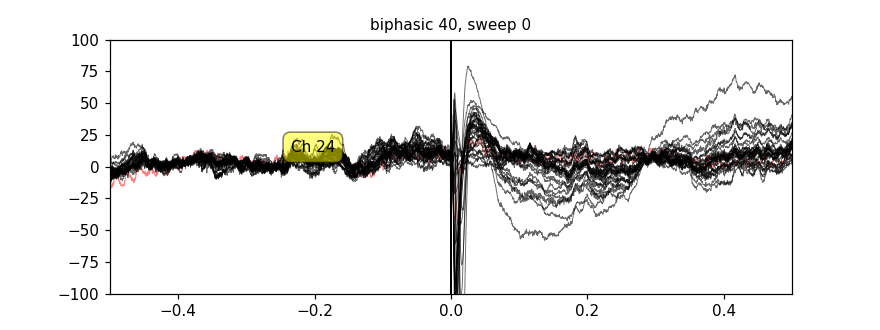

<IPython.core.display.Javascript object>


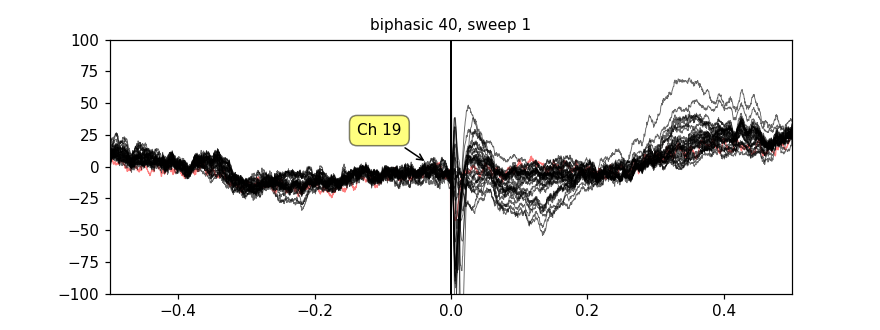

<IPython.core.display.Javascript object>


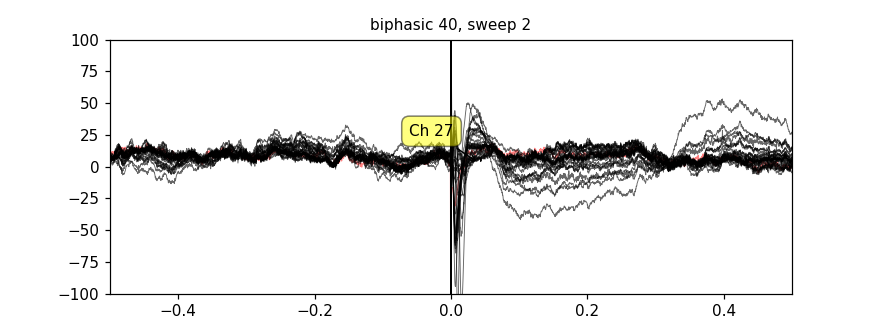

<IPython.core.display.Javascript object>


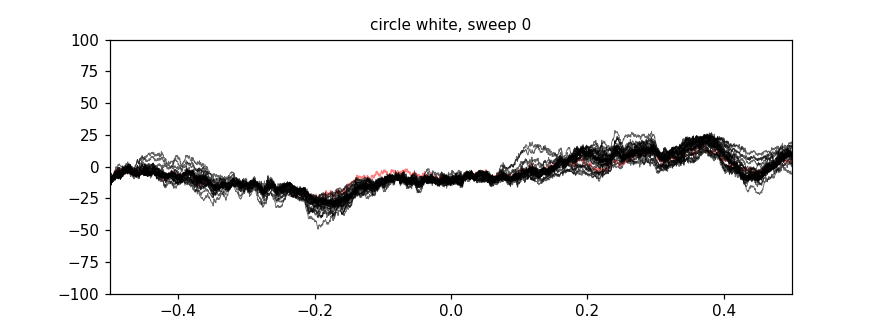

In [23]:
for stimi, paramdict in all_traces.items():
    for parami, sweepdict in paramdict.items():
        for sweepi, datadict in sweepdict.items():
            
            fig, ax = plt.subplots(figsize=(8,3))
            if BAD_CHS.size > 0:
                ax.plot(datadict[0], np.mean(datadict[1], axis=2)[:,BAD_CHS], color='r', linewidth=0.8, alpha=0.5)
            good_chs = ax.plot(datadict[0], np.mean(datadict[1], axis=2)[:,GOOD_CHS], color='k', linewidth=0.6, alpha=0.6)
            for ind, cha in enumerate(good_chs):
                cha.set_label('Ch {}'.format(GOOD_CHS[ind]))
            cursor = mplcursors.cursor(good_chs, hover=True)
            cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))
                
            ax.set_title('{} {}, sweep {:d}'.format(stimi, parami, sweepi))
            ax.set_xlim([-0.5, 0.5])
            ax.set_ylim([-100, 100])

## Compare all trials vs good trials

### Stim evoked traces

In [15]:
plot_before = 1.0 # s, look at 100 ms pre-stim
plot_after = 1.0 # s, look at 500 ms post-stim

low_pass_cutoff = 100

In [18]:
## Loop through all stim events/sweeps and collect traces without removing bad trials
all_traces = {}
for st_type in stim_log.stim_type.unique():
    all_traces[st_type] = {}
    
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
        all_traces[st_type][parami] = {}
        
        sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
        for sweepi in sweep_list:
            print('{}, {} \u03BCA, sweep {:d}'.format(st_type, str(parami), sweepi))
            ## Get event times ##
            events = get_stim_events(stim_log, st_type, parami, sweepi, remove_bad_epochs=False)
            if len(events) == 0:
                print('no good trials found')
                continue
            ## Get event traces ##
            event_traces, event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                events,
                plot_before,
                plot_after,
                exp.ephys_params['EEG']['sample_rate']
            )
            # design/apply lowpass Butterworth filter
            filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
            filttraces = signal.filtfilt(filtb, filta, event_traces, axis=0)
            
            ## Store traces ##
            all_traces[st_type][parami][sweepi] = [event_ts, np.mean(filttraces, axis=2)]

biphasic, 50 μA, sweep 0
biphasic, 50 μA, sweep 1
biphasic, 50 μA, sweep 2
biphasic, 50 μA, sweep 3
biphasic, 70 μA, sweep 0
biphasic, 70 μA, sweep 1
biphasic, 70 μA, sweep 2
biphasic, 70 μA, sweep 3
biphasic, 90 μA, sweep 0
biphasic, 90 μA, sweep 1
biphasic, 90 μA, sweep 2
biphasic, 90 μA, sweep 3
fullscreen, white μA, sweep 0
fullscreen, white μA, sweep 1
fullscreen, white μA, sweep 2


In [19]:
## Loop through all stim events/sweeps and collect traces
clean_traces = {}
for st_type in stim_log.stim_type.unique():
    clean_traces[st_type] = {}
    
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
        clean_traces[st_type][parami] = {}
        
        sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
        for sweepi in sweep_list:
            print('{}, {} \u03BCA, sweep {:d}'.format(st_type, str(parami), sweepi))
            ## Get event times ##
            events = get_stim_events(stim_log, st_type, parami, sweepi)
            if len(events) == 0:
                print('no good trials found')
                continue
            print('Good trials: {:d}'.format(len(events)))
            ## Get event traces ##
            event_traces, event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                events,
                plot_before,
                plot_after,
                exp.ephys_params['EEG']['sample_rate']
            )
            # design/apply lowpass Butterworth filter
            filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
            filttraces = signal.filtfilt(filtb, filta, event_traces, axis=0)
            
            ## Store traces ##
            clean_traces[st_type][parami][sweepi] = [event_ts, np.mean(filttraces, axis=2)]

biphasic, 50 μA, sweep 0
Good trials: 120
biphasic, 50 μA, sweep 1
Good trials: 118
biphasic, 50 μA, sweep 2
Good trials: 117
biphasic, 50 μA, sweep 3
Good trials: 29
biphasic, 70 μA, sweep 0
Good trials: 120
biphasic, 70 μA, sweep 1
Good trials: 105
biphasic, 70 μA, sweep 2
Good trials: 100
biphasic, 70 μA, sweep 3
Good trials: 23
biphasic, 90 μA, sweep 0
Good trials: 118
biphasic, 90 μA, sweep 1
Good trials: 58
biphasic, 90 μA, sweep 2
no good trials found
biphasic, 90 μA, sweep 3
Good trials: 1
fullscreen, white μA, sweep 0
Good trials: 100
fullscreen, white μA, sweep 1
Good trials: 100
fullscreen, white μA, sweep 2
Good trials: 100


### Plotting

Compare all trials to clean trials across different stimuli/sweeps

<IPython.core.display.Javascript object>


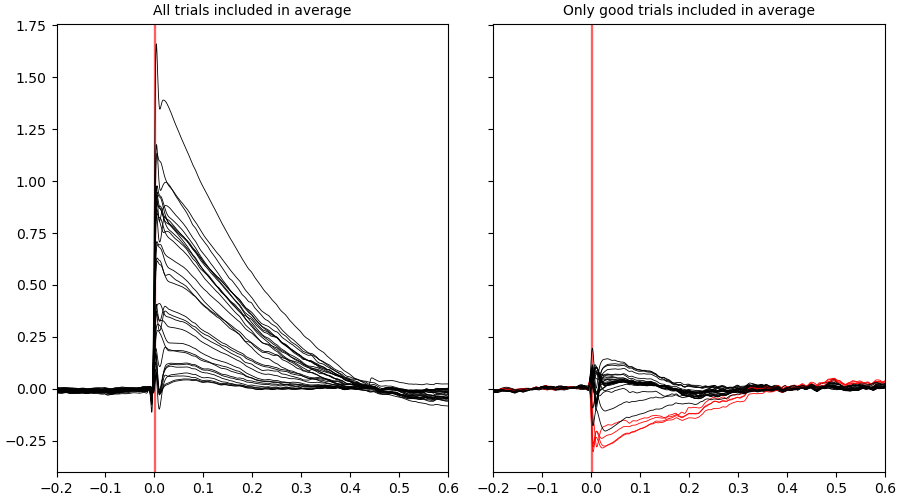

Text(0.5, 1.0, 'Only good trials included in average')

In [22]:
pick_stim = 'biphasic'
pick_param = '90'
pick_sweep = 1

prex = .2 # ms before stim to plot
postx = .6 # ms after stim to plot


fig, axs = plt.subplots(1,2, figsize=(9,5), sharex=True, sharey=True, constrained_layout=True)

## plot average of all trials ##
alltimex = all_traces[pick_stim][pick_param][pick_sweep][0]
alltrials = all_traces[pick_stim][pick_param][pick_sweep][1]/1000 # make them into mV
pinds = np.squeeze(np.argwhere((alltimex >= -prex) & (alltimex <= postx)))
axs[0].plot(alltimex[pinds], alltrials[pinds,:], color='k', linewidth=0.6)
axs[0].axvspan(-.001, .001, color='r', alpha=0.5)
axs[0].set_xlim([-prex, postx])
axs[0].set_title('All trials included in average')

## plot average of only good trials, with bad chs in red ##
cleantimex = clean_traces[pick_stim][pick_param][pick_sweep][0]
cleantrials = clean_traces[pick_stim][pick_param][pick_sweep][1]/1000 # make them into mV
pinds = np.squeeze(np.argwhere((cleantimex >= -prex) & (cleantimex <= postx)))
for cha in eeg_chs:
    if cha in good_chs[pick_stim][pick_param][pick_sweep]:
        linecolor = 'k'
    else:
        linecolor = 'r'
    axs[1].plot(cleantimex[pinds], cleantrials[pinds,cha], color=linecolor, linewidth=0.6)
axs[1].axvspan(-.001, .001, color='r', alpha=0.5)
axs[1].set_title('Only good trials included in average')